In [4]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

In [106]:
import os

folder_path = '../data/'

csv_files = np.array([f for f in os.listdir(folder_path) if f.endswith('.csv')])
csv_files = np.sort(csv_files)[:-1]
print(csv_files)

['2301.csv' '2302.csv' '2303.csv' '2304.csv' '2305.csv' '2306.csv'
 '2307.csv' '2308.csv' '2309.csv' '2310.csv' '2311.csv' '2312.csv'
 '2313.csv' '2314.csv' '2315.csv' '2316.csv' '2317.csv' '2318.csv'
 '2319.csv' '2320.csv' '2321.csv' '2322.csv']


In [107]:
import pandas as pd

In [108]:
df_collar = pd.read_csv("../data/locations.csv")

../data/2301.csv, base freq:75 Hz


Text(0, 0.5, 'Voltage (mV/Am2)')

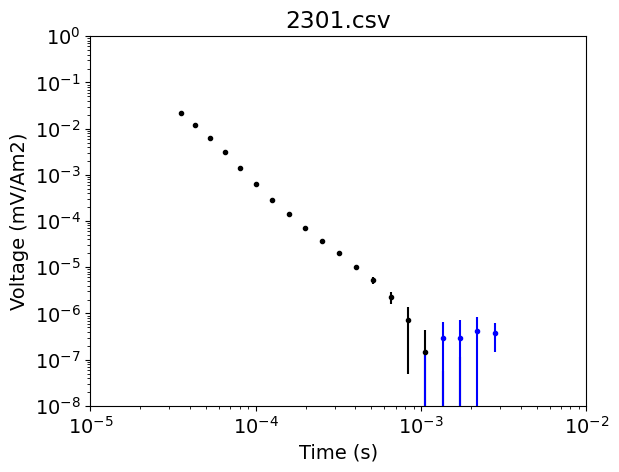

In [109]:
kk = 0
ii = 3
#colors = ['k', 'b']

df = pd.read_csv(folder_path+csv_files[kk])
df_group = df.groupby('f (Hz)')
base_freqs  = list(df_group.groups.keys())

base_freq = base_freqs[ii]
print (f"{folder_path+csv_files[kk]}, base freq:{base_freq:.0f} Hz")
df_tmp = df_group.get_group(base_freq)
voltage = df_tmp['V (mV/Am2)'].values
noise = df_tmp['N (mV/Am2)'].values
times = df_tmp['Time (s)'].values
plt.errorbar(times, voltage, yerr=noise, marker='.', linestyle='None', color='k')
plt.errorbar(times, -voltage, yerr=noise, marker='.', linestyle='None', color='b')
plt.xscale('log')
plt.yscale('log')
# plt.loglog(times, noise, '.')
plt.ylim(1e-8, 1)
plt.xlim(1e-5, 1e-2)
plt.title(csv_files[kk])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV/Am2)")

In [110]:
# Source properties
source_location = np.array([0.0, 0.0, 0.1]) # 0.1 m due to protem being on the ground
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current
source_radius = 56.4  # source loop radius (chosen from an area of 100x100)

# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.1])
receiver_orientation = "z"  # "x", "y" or "z"
#times = np.logspace(-5, -2, 31)  # time channels (s)

# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple component and/or field orientations,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    )
)
rampoff_time=5.1e-6 #taken from email thread
freq = 75.0       
T = 1/freq         
I_peak = 1.0       

# calculate times
t1 = -T/2
t2 = t1 + rampoff_time
t3 = -rampoff_time
t4 = 0.0

time_input_current=np.array([t1, t2, t3, t4])
input_current=np.array([0.0, I_peak, I_peak, 0.0])

# Define the source waveform. Here we define a unit step-off. The definition of
# other waveform types is covered in a separate tutorial.

stepoff_waveform = tdem.sources.PiecewiseLinearWaveform(times=time_input_current, currents=input_current)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

In [111]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(voltage) * np.ones(np.shape(voltage))

In [112]:
data_object = data.Data(survey, dobs=-voltage, standard_deviation=uncertainties)

In [113]:
# estimated host conductivity (S/m)
estimated_conductivity = 0.001

# minimum diffusion distance
d_min = 1250 * np.sqrt(times.min() / estimated_conductivity)
print("MINIMUM DIFFUSION DISTANCE: {} m".format(d_min))

# maximum diffusion distance
d_max = 1250 * np.sqrt(times.max() / estimated_conductivity)
print("MAXIMUM DIFFUSION DISTANCE: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 234.68729194398233 m
MAXIMUM DIFFUSION DISTANCE: 2088.6598574205423 m


In [114]:
depth_min = 1.8  # top layer thickness
depth_max = 300.0  # depth to lowest layer
geometric_factor = 1.15  # rate of thickness increase

In [115]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print(n_layers)


25


In [116]:
log_conductivity_map = maps.ExpMap(nP=n_layers_model)

In [117]:
simulation_L2 = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

In [96]:
#large lake
ice_depth=1.8
water_depth=12.8
conductive_body_1_depth=5
resistive_body_1_depth=150
conductive_body_2_depth=30
#resistive_body_2_depth=200


ice_res=1000
water_res=125.
conductive_body_1_res=18
resistive_body_1_res=1000
conductive_body_2_res=70
resistive_body_2_res=1000

# make hypothesis supose we have talik and no talik but talik thickness changes thin vs thick permafrost with shallower dpeth and deeper depth
layer_thicknesses_model = np.array([ice_depth, water_depth, conductive_body_1_depth, resistive_body_1_depth, conductive_body_2_depth], dtype=float)
resistivities = np.array([ice_res, water_res, conductive_body_1_res, resistive_body_1_res, conductive_body_2_res, resistive_body_2_res], dtype=float)
conductivities = 1.0 / resistivities  # S/m
conductivity_model = np.log(conductivities)
reference_conductivity_model=conductivity_model.copy()

In [97]:
n_layers_model = len(layer_thicknesses_model) + 1

Text(0.5, 0, 'Resistivity (Ω·m)')

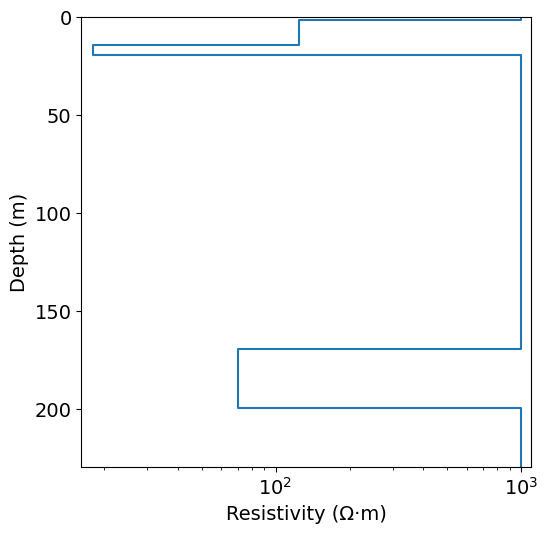

In [98]:
ax = plot_1d_layer_model(layer_thicknesses_model, resistivities)
ax.set_xlabel("Resistivity (Ω·m)")

In [99]:
model_map=maps.ExpMap(nP=n_layers_model)

In [100]:
simulation_L3=tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses_model, sigmaMap=model_map)

In [101]:
source_area = 10000

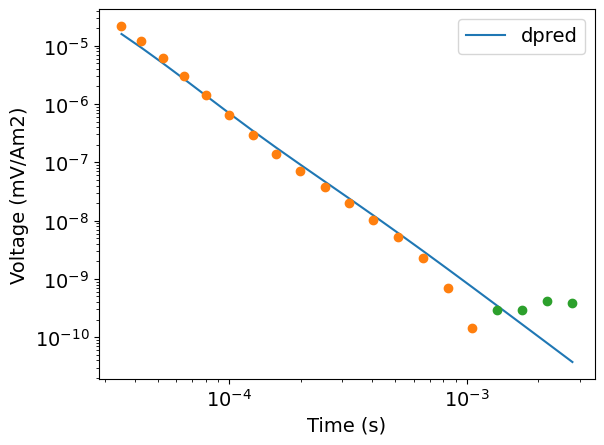

In [102]:
m0 = np.log(1./100 * np.ones(n_layers))
#dpred = simulation_L2.dpred(m0)
dpred2=simulation_L3.dpred(conductivity_model)
ip = voltage * 1e-3 - (-dpred2)
plt.loglog(times, -dpred2, '-', label="dpred")
#plt.loglog(times, -dpred)
plt.loglog(times, voltage*1e-3, 'o')
plt.loglog(times, -voltage*1e-3, 'o')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV/Am2)")
plt.legend()
#plt.loglog(times, ip, 'x')
#plt.loglog(times, -ip, 'x')
#print(n_layers)
#print(n_layers_model)

In [438]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L3, data=data_object)

In [439]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 25 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     25       -376.31         -0.00      1.80     44.80    1.15




In [466]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

ValueError: 'reference_model' must be (25,), got (6,)

In [416]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

In [410]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [411]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, starting_beta, beta_schedule, target_misfit]

In [412]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(conductivity_model)


Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


ValueError: Model of len(6) incorrect shape for mappings: 
    sigmaMap: expected model of len(25) for ExpMap(25,25)

In [413]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times, np.abs(dobs), "k-o")
ax1.loglog(times, np.abs(dpred_L2), "b-o")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (T)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion"], loc="upper right")
plt.show()

NameError: name 'recovered_model_L2' is not defined